In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Aug 10 09:27:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files
import os
import requests
import re

import collections
import pandas as pd
from nltk import word_tokenize
import nltk
from nltk import pos_tag
import matplotlib.pyplot as plt
from wordcloud import WordCloud

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
# download gpt2 models.  
#gpt2.download_gpt2(model_name="124M")
gpt2.download_gpt2(model_name="355M")
#gpt2.download_gpt2(model_name="774M")
#gpt2.download_gpt2(model_name="1558M")

Fetching checkpoint: 1.05Mit [00:00, 306Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 4.34Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 295Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [01:10, 20.1Mit/s]                                 
Fetching model.ckpt.index: 1.05Mit [00:00, 192Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 4.36Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 5.63Mit/s]


###legacy:  
If dataset hasn't been created and splited to train & test dataset

In [ ]:
#  copy models to google drive if you want
!cp -r /content/models /content/drive/MyDrive 

In [ ]:
# load dataset
file_name = "HarryPotter.txt"

# if no dataset here, create a HarryPotter dataset
if not os.path.isfile(file_name):
	url = "https://raw.githubusercontent.com/YanWang20121865/MSc2021YanWang/main/Second%20update/Dataset/HarryPotter.txt"
	data = requests.get(url)
	
	with open(file_name, 'w') as f:
		f.write(data.text)

In [ ]:
!export PYTHONIOENCODING=UTF-8

In [ ]:
def train_test_split_fun(file_name, num):
  if 0 < num < 1:
    # open original txt file
    text = open(file_name+'.txt',"r", encoding='UTF-8').read()    
    # split each line of content in text file 
    b=re.split('\n',text)

    # check how many lines in total
    n=0
    for i in b:
      n+=1
    print(n)

    # generage train.txt and test.txt files
    f1 = open(file_name+'_train.txt','a')
    f2 = open(file_name+'_test.txt','a')
    m=0
    for i in b:
      m+=1
      if m<=n*num:    # train : test = num
        f1.write(i)
      else:
        f2.write(i)
    #close files
    f1.close()
    f2.close()
  else:
    print("The training data ratio must between 0 and 1.0! ")

In [ ]:
# code for spliting train & test dataset
num = 0.8
file_name = 'HarryPotter'
train_test_split_fun(file_name, num)

###copy dataset from google drive here

In [5]:
# copy datasets 
!cp -r /content/drive/MyDrive/Dataset/* /content

In [6]:
# load checkpoint to google drive if in need( if you want to restart training from existed checkpoint)
!cp -r /content/drive/MyDrive/checkpoint/ /content/checkpoint/

In [7]:
# set file name and model_name for training and generating
file_name = 'dataset_top1000'
model_name = '355M'

###Train model:

In [ ]:
sess = gpt2.start_tf_sess()
gpt2.finetune(sess,
              dataset=file_name+'_train.txt',
              model_name=model_name,
              steps=10000,
              #Set to fresh to start training from the base GPT-2, or set to latest to restart training from an existing checkpoint.
              restore_from='latest',   
              run_name='run_'+model_name+'_'+file_name,
              print_every=10,
              sample_every=250,
              save_every=500,
              
              )

In [ ]:
# save checkpoint to google drive 
!cp -r /content/checkpoint/ /content/drive/MyDrive

###Generate story txt file:  

In [8]:
# load the model we trained
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run_'+model_name+'_'+file_name)

Loading checkpoint checkpoint/run_355M_dataset_top1000/model-69501
INFO:tensorflow:Restoring parameters from checkpoint/run_355M_dataset_top1000/model-69501


In [153]:
# generate txt files to save stories
# path for generated file
gen_file = '/content/drive/MyDrive/Generated Story/run_'+model_name+'_'+file_name+'/{:%Y%m%d_%H%M%S}/'.format(datetime.utcnow())
os.makedirs(gen_file)


In [154]:
start = input("Starting sentence:")
gpt2.generate_to_file(sess,
                      run_name='run_'+model_name+'_'+file_name,
                      destination_path=gen_file+'story.txt',
                      prefix=start,  # input starting sentence
                      length=500,   # set max length of generated story
                      temperature=0.9,  # The higher the temperature, the crazier the text
                      nsamples=1,   # set number of generated stories, can generate several samples simultaneously
                      batch_size=1,
                      )

Starting sentence:Vampires cannot enter a house uninvited. Turns out, they invented Welcome mats to bypass this rule decades ago.


#statistics & visualization

In [155]:
# read generated story file
with open(gen_file+'story.txt','r+',encoding='UTF-8') as f:
  t = f.read()
  print(t)

Vampires cannot enter a house uninvited. Turns out, they invented Welcome mats to bypass this rule decades ago. From the inside of the house, one can see the outside, and the inner thought. They look up to you from whatever they feel like they should be seeing. Behind the stuffies, the actual people, the ones not looking at the aliens, the orders they wait for from the "higher-ups", they all come from the same source. The Anglian.The Anglian let the invasion begin because they *want to rule everything by force*. The Anglian has no love for anybody. They don't like their own people. Everyone is afraid of the other *and* the easy way around. One day, the Anglian was going to a gathering of them and they found themselves. Nomad, the street-walker type we're here to meet and greet and know over voice communication. Had no problems understanding me. I don't know why he was there. I mean, when you're coming from a place with just about no culture and play anyway... eventually they get bored 

###Pre-precess

In [156]:
# tokenize words
w = word_tokenize(t)
print(w)

['Vampires', 'can', 'not', 'enter', 'a', 'house', 'uninvited', '.', 'Turns', 'out', ',', 'they', 'invented', 'Welcome', 'mats', 'to', 'bypass', 'this', 'rule', 'decades', 'ago', '.', 'From', 'the', 'inside', 'of', 'the', 'house', ',', 'one', 'can', 'see', 'the', 'outside', ',', 'and', 'the', 'inner', 'thought', '.', 'They', 'look', 'up', 'to', 'you', 'from', 'whatever', 'they', 'feel', 'like', 'they', 'should', 'be', 'seeing', '.', 'Behind', 'the', 'stuffies', ',', 'the', 'actual', 'people', ',', 'the', 'ones', 'not', 'looking', 'at', 'the', 'aliens', ',', 'the', 'orders', 'they', 'wait', 'for', 'from', 'the', '``', 'higher-ups', "''", ',', 'they', 'all', 'come', 'from', 'the', 'same', 'source', '.', 'The', 'Anglian.The', 'Anglian', 'let', 'the', 'invasion', 'begin', 'because', 'they', '*want', 'to', 'rule', 'everything', 'by', 'force*', '.', 'The', 'Anglian', 'has', 'no', 'love', 'for', 'anybody', '.', 'They', 'do', "n't", 'like', 'their', 'own', 'people', '.', 'Everyone', 'is', 'afra

In [157]:
# tagging the part of speech each word belongs to
tw = pos_tag(w)
print(tw)

[('Vampires', 'NNS'), ('can', 'MD'), ('not', 'RB'), ('enter', 'VB'), ('a', 'DT'), ('house', 'NN'), ('uninvited', 'JJ'), ('.', '.'), ('Turns', 'VBZ'), ('out', 'RP'), (',', ','), ('they', 'PRP'), ('invented', 'VBD'), ('Welcome', 'NNP'), ('mats', 'NNS'), ('to', 'TO'), ('bypass', 'VB'), ('this', 'DT'), ('rule', 'NN'), ('decades', 'VBZ'), ('ago', 'RB'), ('.', '.'), ('From', 'IN'), ('the', 'DT'), ('inside', 'NN'), ('of', 'IN'), ('the', 'DT'), ('house', 'NN'), (',', ','), ('one', 'CD'), ('can', 'MD'), ('see', 'VB'), ('the', 'DT'), ('outside', 'JJ'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('inner', 'JJ'), ('thought', 'NN'), ('.', '.'), ('They', 'PRP'), ('look', 'VBP'), ('up', 'RP'), ('to', 'TO'), ('you', 'PRP'), ('from', 'IN'), ('whatever', 'WDT'), ('they', 'PRP'), ('feel', 'VBP'), ('like', 'IN'), ('they', 'PRP'), ('should', 'MD'), ('be', 'VB'), ('seeing', 'VBG'), ('.', '.'), ('Behind', 'IN'), ('the', 'DT'), ('stuffies', 'NNS'), (',', ','), ('the', 'DT'), ('actual', 'JJ'), ('people', 'NNS')

In [158]:
# extract the names and spaces from the story
name = []
for i in tw:
  if i[1] in ('NNP','NNPS'):
    name.append(i[0])
print(name)

['Welcome', 'Anglian.The', 'Anglian', 'Anglian', 'Anglian', 'Nomad', 'Sounds', 'Uzbek', 'Meme', 'Borg', 'Just', 'North']


In [159]:
# do pre-process to story file

# Convert to lower case
t = t.lower()
# Replaces URLs with the word URL
t = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', t)
w = word_tokenize(t)

tmp = []
word_cleaned = []
for i in w:
# Remove punctuation
  i = i.strip('\'“”&"?!,.():;``')
  # Convert more than 2 letter repetitions to 2 letter
  i = re.sub(r'(.)\1+', r'\1\1', i)
  # Remove - & '
  i = re.sub(r'(-|\')', '', i)
  # keep the initial of names and places in the story in capital letter 
  if i.capitalize() in name:
    i = i.capitalize()
  if i is not '':
    tmp.append(i)
print('tmp: ',tmp)

# remove stopwords
stop_words = nltk.corpus.stopwords.words('english')
for i in tmp:
  if i not in stop_words:
    word_cleaned.append(i)  
w = word_cleaned
print('final wordlist:',w)

tmp:  ['vampires', 'can', 'not', 'enter', 'a', 'house', 'uninvited', 'turns', 'out', 'they', 'invented', 'Welcome', 'mats', 'to', 'bypass', 'this', 'rule', 'decades', 'ago', 'from', 'the', 'inside', 'of', 'the', 'house', 'one', 'can', 'see', 'the', 'outside', 'and', 'the', 'inner', 'thought', 'they', 'look', 'up', 'to', 'you', 'from', 'whatever', 'they', 'feel', 'like', 'they', 'should', 'be', 'seeing', 'behind', 'the', 'stuffies', 'the', 'actual', 'people', 'the', 'ones', 'not', 'looking', 'at', 'the', 'aliens', 'the', 'orders', 'they', 'wait', 'for', 'from', 'the', 'higherups', 'they', 'all', 'come', 'from', 'the', 'same', 'source', 'the', 'anglian.the', 'Anglian', 'let', 'the', 'invasion', 'begin', 'because', 'they', '*want', 'to', 'rule', 'everything', 'by', 'force*', 'the', 'Anglian', 'has', 'no', 'love', 'for', 'anybody', 'they', 'do', 'nt', 'like', 'their', 'own', 'people', 'everyone', 'is', 'afraid', 'of', 'the', 'other', '*and*', 'the', 'easy', 'way', 'around', 'one', 'day', '

###Count words

In [160]:
# count the number of each word
word_count = {}
for i in w:
  if i in word_count:
    word_count[i] += 1
  else:
    word_count[i] = 1
print(word_count)

{'vampires': 1, 'enter': 1, 'house': 2, 'uninvited': 1, 'turns': 1, 'invented': 1, 'Welcome': 1, 'mats': 1, 'bypass': 1, 'rule': 2, 'decades': 1, 'ago': 1, 'inside': 1, 'one': 3, 'see': 2, 'outside': 1, 'inner': 1, 'thought': 1, 'look': 1, 'whatever': 1, 'feel': 1, 'like': 4, 'seeing': 1, 'behind': 1, 'stuffies': 1, 'actual': 1, 'people': 2, 'ones': 2, 'looking': 1, 'aliens': 4, 'orders': 1, 'wait': 1, 'higherups': 1, 'come': 1, 'source': 1, 'anglian.the': 1, 'Anglian': 3, 'let': 2, 'invasion': 2, 'begin': 1, '*want': 1, 'everything': 2, 'force*': 1, 'love': 1, 'anybody': 1, 'nt': 3, 'everyone': 1, 'afraid': 1, '*and*': 1, 'easy': 1, 'way': 1, 'around': 1, 'day': 1, 'going': 2, 'gathering': 1, 'found': 1, 'Nomad': 1, 'streetwalker': 1, 'type': 1, 'meet': 1, 'greet': 1, 'know': 4, 'voice': 1, 'communication': 1, 'problems': 1, 'understanding': 1, 'mean': 2, 'coming': 1, 'place': 1, 'Just': 2, 'culture': 1, 'play': 1, 'anyway': 1, 'eventually': 1, 'get': 1, 'bored': 1, 'switch': 1, 'inst

### split the part of speech

In [161]:
# extract the noun 
noun = []
for i in tw:
  if i[1] in ('NN','NNS','NNP','NNPS'):
    noun.append(i[0])
print(noun)

['Vampires', 'house', 'Welcome', 'mats', 'rule', 'inside', 'house', 'thought', 'stuffies', 'people', 'ones', 'aliens', 'orders', 'source', 'Anglian.The', 'Anglian', 'invasion', 'begin', 'everything', 'force*', 'Anglian', 'love', 'anybody', 'people', 'Everyone', 'way', 'day', 'Anglian', 'gathering', 'Nomad', 'street-walker', 'type', 'communication', 'problems', 'place', 'culture', 'messenger', 'days', 'Sounds', 'phone', 'call', 'kobbler', 'lots', 'memes', 'world', 'time', 'home', 'leader', 'something', 'problem', 'everybody', 'aliens', 'Complacency', 'supply', 'Uzbek', 'world', 'Meme', 'Borg', 'question', 'middle', 'difference', 'Just', 'home', 'everything', 'Cuz', 'North', 'ones', 'year', 'aliens', 'aliens', 'names', 'agents', 'mission', 'gadgets', 'gearheads', 'technology', 'alien', 'invasion', 'year', 'half', 'mission']


In [162]:
# extract verb
verb = []
for i in tw:
  if i[1] in ('VB','VBD','VBG','VBN','VBP','VBZ'):
    verb.append(i[0])
print(verb)

['enter', 'Turns', 'invented', 'bypass', 'decades', 'see', 'look', 'feel', 'be', 'seeing', 'looking', 'wait', 'come', 'let', '*want', 'rule', 'has', 'do', 'like', 'is', 'afraid', '*and*', 'was', 'going', 'found', "'re", 'meet', 'greet', 'know', 'Had', 'understanding', 'do', 'know', 'was', 'mean', "'re", 'coming', 'play', 'get', 'bored', 'switch', 'instant', 'stuck', 'have', "'s", 'go', 'become', "'s", 'came', 'dropped', "'re", 'fleeing', 'does', 'sound', 'know', "'s", 'happening', 'are', 'going', 'do', "'s", "'ve", 'got', "'m", 'Let', 'see', 'make', 'go', 'tell', "'m", "'re", 'flying', "'s", 'hit', 'save', 'know', 'do', 'go', 'believe', "'m", 'public.The', 'are', "'re", 'frightened', 'attached', 'mean', 'tell', "'s", 'has', 'been', 'escalating', 'is']


In [163]:
# extract adjective
adj = []
for i in tw:
  if i[1] in ('JJ','JJR','JJS'):
    adj.append(i[0])
print(adj)


['uninvited', 'outside', 'inner', 'actual', 'higher-ups', 'same', 'own', 'other', 'easy', 'voice', 'old', 'weird', '30-minute', 'bad', 'funny', 'large', 'enough', 'cult', 'same', 'first', 'much', 'first', 'Agent', 'pretty', 'little', 'other', 'much', 'same', 'cautious', 'intertribal', 'OK', 'whole', 'past', 'extravagant']


In [164]:
# extract adverb
adv = []
for i in tw:
  if i[1] in ('RB','RBR','RBS'):
    adv.append(i[0])
print(adv)

['not', 'ago', 'not', "n't", 'here', "n't", 'there', 'just', 'anyway', 'eventually', 'so', 'not', 'back', 'not', 'here', 'here', 'also', "n't", 'sometimes', 'too', 'pretty', 'not', 'steadily', 'too']


###Count number of word in each part of speech

In [165]:
# extract the count of noun
freq_noun = {}
for i in word_count.keys():
  if i in noun:
    freq_noun[i] = word_count[i]
print(freq_noun)

# count total number and proportion of noun in this text file
prop_noun = len(freq_noun)/len(tmp)
print('number of noun in this paper:',len(freq_noun))
print('The proportion of noun in the text is:',prop_noun)

# change to dataframe and sort them
df_noun = pd.DataFrame.from_dict(freq_noun, orient='index',columns=['count']).sort_values(by=['count'],ascending=False)
df_noun = df_noun.reset_index().rename(columns={'index':'noun'})
#df_noun = df_noun.sort_values(by=['count'],ascending=False)
df_noun

{'house': 2, 'Welcome': 1, 'mats': 1, 'rule': 2, 'inside': 1, 'thought': 1, 'stuffies': 1, 'people': 2, 'ones': 2, 'aliens': 4, 'orders': 1, 'source': 1, 'Anglian': 3, 'invasion': 2, 'begin': 1, 'everything': 2, 'force*': 1, 'love': 1, 'anybody': 1, 'way': 1, 'day': 1, 'gathering': 1, 'Nomad': 1, 'type': 1, 'communication': 1, 'problems': 1, 'place': 1, 'Just': 2, 'culture': 1, 'messenger': 1, 'days': 1, 'Sounds': 1, 'phone': 1, 'call': 1, 'kobbler': 1, 'lots': 1, 'memes': 1, 'world': 2, 'time': 1, 'home': 2, 'leader': 1, 'something': 1, 'problem': 1, 'everybody': 1, 'supply': 1, 'Uzbek': 1, 'Meme': 1, 'Borg': 1, 'question': 1, 'middle': 1, 'difference': 1, 'North': 1, 'year': 2, 'names': 1, 'agents': 1, 'mission': 2, 'gadgets': 1, 'gearheads': 1, 'technology': 1, 'alien': 1, 'half': 1}
number of noun in this paper: 61
The proportion of noun in the text is: 0.14352941176470588


,noun,count
0,aliens,4
1,Anglian,3
2,house,2
3,ones,2
4,year,2
...,...,...
56,messenger,1
57,Welcome,1
58,Sounds,1
59,phone,1


In [166]:
# extract the count of verb
freq_verb = {}
for i in word_count.keys():
  if i in verb:
    freq_verb[i] = word_count[i]
print(freq_verb)

# count total number and proportion of verb in this text file
prop_verb = len(freq_verb)/len(tmp)
print('number of verb in this paper:',len(freq_verb))
print('The proportion of verb in the text is:',prop_verb)

# change to dataframe and sort them
df_verb = pd.DataFrame.from_dict(freq_verb, orient='index',columns=['count']).sort_values(by=['count'],ascending=False)
df_verb = df_verb.reset_index().rename(columns={'index':'verb'})
df_verb

{'enter': 1, 'invented': 1, 'bypass': 1, 'rule': 2, 'decades': 1, 'see': 2, 'look': 1, 'feel': 1, 'like': 4, 'seeing': 1, 'looking': 1, 'wait': 1, 'come': 1, 'let': 2, '*want': 1, 'afraid': 1, '*and*': 1, 'going': 2, 'found': 1, 'meet': 1, 'greet': 1, 'know': 4, 'understanding': 1, 'mean': 2, 'coming': 1, 'play': 1, 'get': 1, 'bored': 1, 'switch': 1, 'instant': 1, 'stuck': 1, 'go': 3, 'become': 1, 'came': 1, 'dropped': 1, 'fleeing': 1, 'sound': 1, 'happening': 1, 'got': 1, 'make': 1, 'tell': 2, 'flying': 1, 'hit': 1, 'save': 1, 'believe': 1, 'frightened': 1, 'attached': 1, 'escalating': 1}
number of verb in this paper: 48
The proportion of verb in the text is: 0.11294117647058824


,verb,count
0,like,4
1,know,4
2,go,3
3,let,2
4,rule,2
5,see,2
6,mean,2
7,tell,2
8,going,2
9,sound,1


In [167]:
# extract the count of adj
freq_adj = {}
for i in word_count.keys():
  if i in adj:
    freq_adj[i] = word_count[i]
print(freq_adj)

# count total number and proportion of adj in this text file
prop_adj = len(freq_adj)/len(tmp)
print('number of adj in this paper:',len(freq_adj))
print('The proportion of adj in the text is:',prop_adj)

# change to dataframe and sort them
df_adj = pd.DataFrame.from_dict(freq_adj, orient='index',columns=['count']).sort_values(by=['count'],ascending=False)
df_adj = df_adj.reset_index().rename(columns={'index':'adj'})
df_adj

{'uninvited': 1, 'outside': 1, 'inner': 1, 'actual': 1, 'easy': 1, 'voice': 1, 'old': 1, 'weird': 1, 'bad': 1, 'funny': 1, 'large': 1, 'enough': 1, 'cult': 1, 'first': 2, 'much': 2, 'pretty': 2, 'little': 1, 'cautious': 1, 'intertribal': 1, 'whole': 1, 'past': 1, 'extravagant': 1}
number of adj in this paper: 22
The proportion of adj in the text is: 0.05176470588235294


,adj,count
0,pretty,2
1,much,2
2,first,2
3,uninvited,1
4,outside,1
5,past,1
6,whole,1
7,intertribal,1
8,cautious,1
9,little,1


In [168]:
# extract the count of adv
freq_adv = {}
for i in word_count.keys():
  if i in adv:
    freq_adv[i] = word_count[i]
print(freq_adv)

# count total number and proportion of adv in this text file
prop_adv = len(freq_adv)/len(tmp)
print('number of adv in this paper:',len(freq_adv))
print('The proportion of adv in the text is:',prop_adv)

# change to dataframe and sort them
df_adv = pd.DataFrame.from_dict(freq_adv, orient='index',columns=['count']).sort_values(by=['count'],ascending=False)
df_adv = df_adv.reset_index().rename(columns={'index':'adv'})
df_adv

{'ago': 1, 'anyway': 1, 'eventually': 1, 'back': 1, 'pretty': 2, 'also': 1, 'sometimes': 1, 'steadily': 1}
number of adv in this paper: 8
The proportion of adv in the text is: 0.018823529411764704


,adv,count
0,pretty,2
1,ago,1
2,anyway,1
3,eventually,1
4,back,1
5,also,1
6,sometimes,1
7,steadily,1


###create csv file to save word count statistics

In [169]:
with open(gen_file+'story_wordcount.csv', 'w', encoding='utf-8') as f2:
  pd.DataFrame(columns=['word_count_statistics']).to_csv(f2, index=False) # remove index here

  df_noun.to_csv(f2, mode='a+')
  df_verb.to_csv(f2, mode='a+')
  df_adj.to_csv(f2, mode='a+')
  df_adv.to_csv(f2, mode='a+')

df2 = pd.read_csv(gen_file+'story_wordcount.csv')
print(df2)


               word_count_statistics
NaN noun                       count
0.0 aliens                         4
1.0 Anglian                        3
2.0 house                          2
3.0 ones                           2
...                              ...
    eventually                     1
4.0 back                           1
5.0 also                           1
6.0 sometimes                      1
7.0 steadily                       1

[143 rows x 1 columns]


###use word frequency calculation method to extract keywords

In [170]:
key_word_candidate = []
df_key = pd.DataFrame.from_dict(word_count, orient='index',columns=['count']).sort_values(by=['count'],ascending=False)

# select the most frequently fifteen words in this text file as candidate of key_words
for i in range(15):
  key_word_candidate.append(df_key.index[i])
print(key_word_candidate)

['aliens', 'know', 'like', 'nt', 'go', 'one', 'Anglian', 'tell', 'year', 'ones', 'mean', 'let', 'pretty', 'invasion', 'everything']


In [171]:
# list to str
Keyword_candidate = ",".join(key_word_candidate)
print(Keyword_candidate)

aliens,know,like,nt,go,one,Anglian,tell,year,ones,mean,let,pretty,invasion,everything


In [172]:
# append total number of words and key word candidates information in original text file
with open(gen_file+'story.txt','a+',encoding='UTF-8') as f:
  f.write("\n\nTotal number of words in this text file is : "+ str(len(tmp))+'\n')
  f.write('Key Word candidate: '+Keyword_candidate+'\n')
  t2 = f.read()
  print(t2)

##Visualization

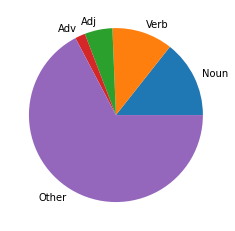

In [173]:
# create a part-of-speech pie chart 
other = 1 - prop_noun - prop_verb - prop_adj - prop_adv
labels ='Noun','Verb','Adj','Adv','Other'
fraces = [prop_noun,prop_verb,prop_adj,prop_adv,other]
plt.pie(x=fraces,labels= labels)
plt.savefig(gen_file+'story_wordcount_piechart.jpg')
plt.show()


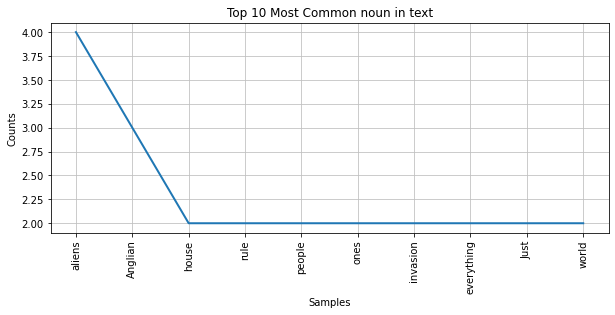

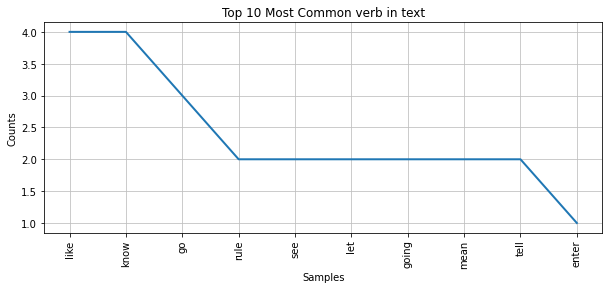

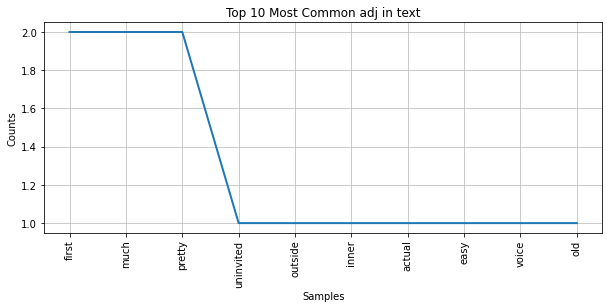

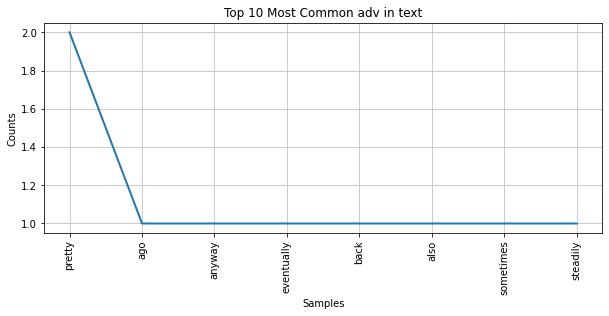

In [174]:
# use NLTK to generate figures for noun, verb, adj, adv
Freq_noun=nltk.FreqDist(freq_noun)
Freq_verb=nltk.FreqDist(freq_verb)
Freq_adj=nltk.FreqDist(freq_adj)
Freq_adv=nltk.FreqDist(freq_adv)

#show figures and save them as png. 
#Number of words on X-axes is configurable
fig = plt.figure(figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15) # to avoid x-ticks cut-off
Freq_noun.plot(10, title='Top 10 Most Common noun in text')
fig.savefig(gen_file+'story_top10_noun.png', bbox_inches = "tight")

fig = plt.figure(figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15) # to avoid x-ticks cut-off
Freq_verb.plot(10, title='Top 10 Most Common verb in text')
fig.savefig(gen_file+'story_top10_verb.png', bbox_inches = "tight")

fig = plt.figure(figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15) # to avoid x-ticks cut-off
Freq_adj.plot(10, title='Top 10 Most Common adj in text')
fig.savefig(gen_file+'story_top10_adj.png', bbox_inches = "tight")

fig = plt.figure(figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15) # to avoid x-ticks cut-off
Freq_adv.plot(10, title='Top 10 Most Common adv in text')
fig.savefig(gen_file+'story_top10_adv.png', bbox_inches = "tight")

plt.show()

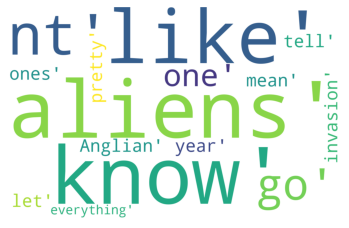

In [175]:
# use wordcloud to generate png for keywords candidate
wordcloud = WordCloud(
        background_color="white", # Set the background to white , default is black
        width=1500,              #Set width of figure
        height=960,              #Set height of figure
        margin=10               #Set margin of figure
        ).generate(str(key_word_candidate))
# generate figure
plt.imshow(wordcloud)
# remove axes
plt.axis("off")

fig.show()
# save figure as png
wordcloud.to_file(gen_file+'story_keywordcloud.png')

In [176]:
# may have to run twice to get file to download
#files.download(gen_file)